neural_network

# Custom Feedforward Network

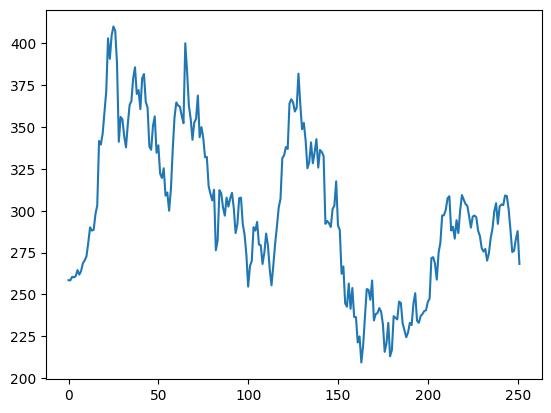

In [112]:
from pandas import read_csv
from datetime import datetime
from pandas.plotting import autocorrelation_plot
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, LSTM
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


# Ensure eager execution
tf.config.run_functions_eagerly(True)

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

def parser(x):
	return datetime.strptime(x,'%Y-%m-%d')

series = read_csv('data/cleaned_data_bert.csv', header=0, parse_dates=[0], index_col=0)

# Filter rows where "Stock Name" is 'TLSA'
series = series[series['Stock Name'] == 'TSLA']
series = series.drop(['Stock Name', 'Adj Close'], axis=1)
series["Close"].plot()
plt.show()

In [86]:
# autocorrelation_plot(series)
# plt.show()

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.8489
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.5646
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4197
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9246
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6804
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5190
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4632
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3446
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2510
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2702
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2272
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1259
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1935
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1568
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1843
Epoch 16/100
7/7 ━━

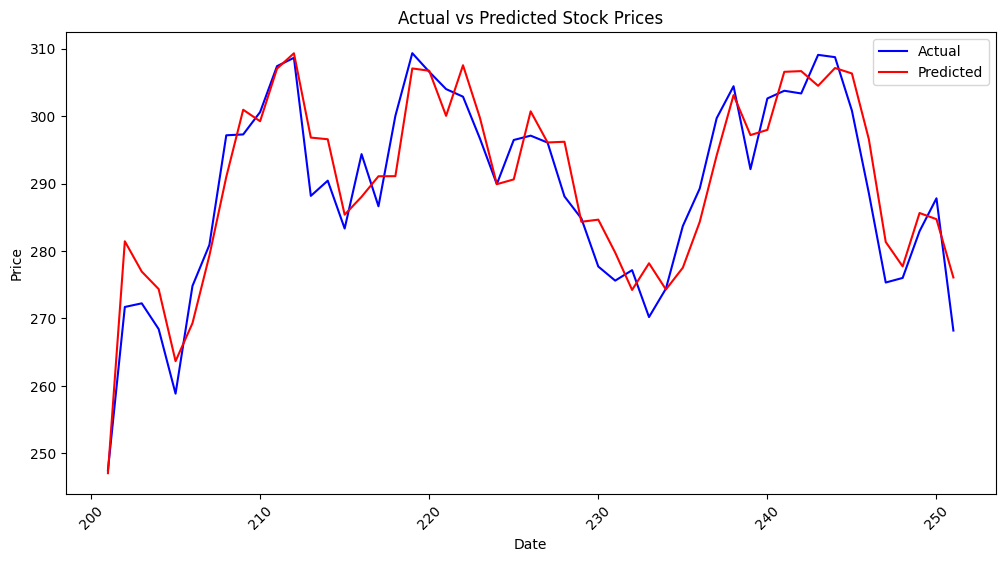

Mean Squared Error: 23.869269277613775


In [113]:
# Define the target variable (y) and the features (X)
y = series['Close']
X = series.drop(['Close', 'Date'], axis=1)  # Drop 'Date' from the features

# Split into train and test (80% train, 20% test)
train_size = int(len(series) * 0.8)  # 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Scale the features (X) using StandardScaler
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target variable (y) using StandardScaler
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # Reshape for compatibility
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Define the model
model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=X_train_scaled.shape[1]))  # Fewer units
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32)

# Predict on the test data (predictions are scaled)
forecast_scaled = model.predict(X_test_scaled)

# Reshape forecast to 1D
forecast_scaled = forecast_scaled.reshape(-1)

# Inverse transform the forecast to get original scale values
forecast = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1))

# Convert y_test to numpy for consistency with forecast
y_test_dates = y_test.index.to_numpy()

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_dates, y_test.values, label='Actual', color='blue')  # Actual values
plt.plot(y_test_dates, forecast, label='Predicted', color='red')  # Predicted values
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate date labels for readability
plt.show()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, forecast)
print(f'Mean Squared Error: {mse}')


# CNN + LSTM

Epoch 1/20
5/5 - 1s - 159ms/step - loss: 0.9415 - val_loss: 0.0786
Epoch 2/20
5/5 - 1s - 138ms/step - loss: 0.7525 - val_loss: 0.0709
Epoch 3/20
5/5 - 1s - 141ms/step - loss: 0.5860 - val_loss: 0.0751
Epoch 4/20
5/5 - 1s - 140ms/step - loss: 0.6079 - val_loss: 0.0718
Epoch 5/20
5/5 - 1s - 135ms/step - loss: 0.4842 - val_loss: 0.1106
Epoch 6/20
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\ericl\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\rnn.py", line 418, in <genexpr>
    output_ta_t = tuple(  File "C:\Users\ericl\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
5/5 - 1s - 170ms/step - loss: 0.4561 - val_loss: 0.

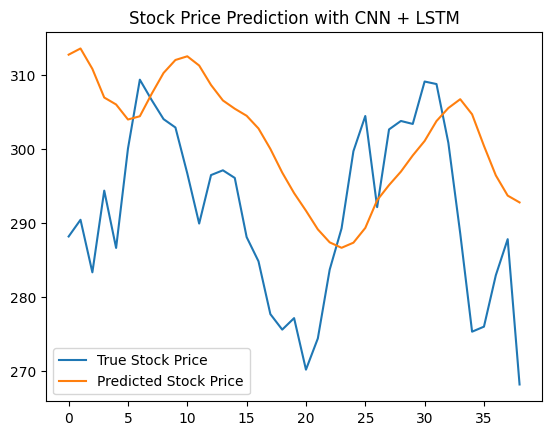

In [ ]:
# Load data
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

series = read_csv('data/stock_yfinance_data.csv', header=0, parse_dates=[0], index_col=0)
# Filter rows where "Stock Name" is 'TLSA'
series = series[series['Stock Name'] == 'TSLA']
series = series.drop(['Stock Name', 'Adj Close'], axis=1)

# Scale only the 'Close' price
scaler = StandardScaler()
scaled = scaler.fit_transform(series[['Close']].values)  # Scale only the 'Close' price

# Function to create data sequences for time-series forecasting
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])  # Use only 'Close' price
        y.append(data[i + look_back, 0])  # Predict the next 'Close' price
    return np.array(X), np.array(y)

# Prepare the data
look_back = 60
X, y = create_dataset(scaled, look_back)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for CNN (samples, time steps, features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the CNN + LSTM hybrid model
model = Sequential()

# CNN layers for feature extraction
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer for capturing temporal dependencies
model.add(LSTM(50, activation='relu'))

# Fully connected layer to output the predicted stock price
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.add(Dropout(0.2)) 

early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2, callbacks=[early_stop])

# Evaluate the model
mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on Test Set: {mse}")

# Predict
y_pred = model.predict(X_test)

# Rescale predictions back to original scale using the same scaler
y_pred_rescaled = scaler.inverse_transform(y_pred)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

# Plot the results
import matplotlib.pyplot as plt
plt.plot(y_test_rescaled, label='True Stock Price')
plt.plot(y_pred_rescaled, label='Predicted Stock Price')
plt.title('Stock Price Prediction with CNN + LSTM')
plt.legend()
plt.show()


# LSTM using sequences

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 351ms/step - loss: 0.2061 - val_loss: 0.0079
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - loss: 0.0409 - val_loss: 0.0107
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 340ms/step - loss: 0.0271 - val_loss: 0.0083
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - loss: 0.0229 - val_loss: 0.0078
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - loss: 0.0211 - val_loss: 0.0044
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 345ms/step - loss: 0.0163 - val_loss: 0.0071
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 335ms/step - loss: 0.0181 - val_loss: 0.0043
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - loss: 0.0176 - val_loss: 0.0042
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - loss: 0.0145 - val_loss: 0.0041
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step - loss: 0.0125 - val_loss: 0.0044
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step - loss: 0.0140 - val_loss: 0.0048
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 350ms/step - loss: 0.0136 - val_lo

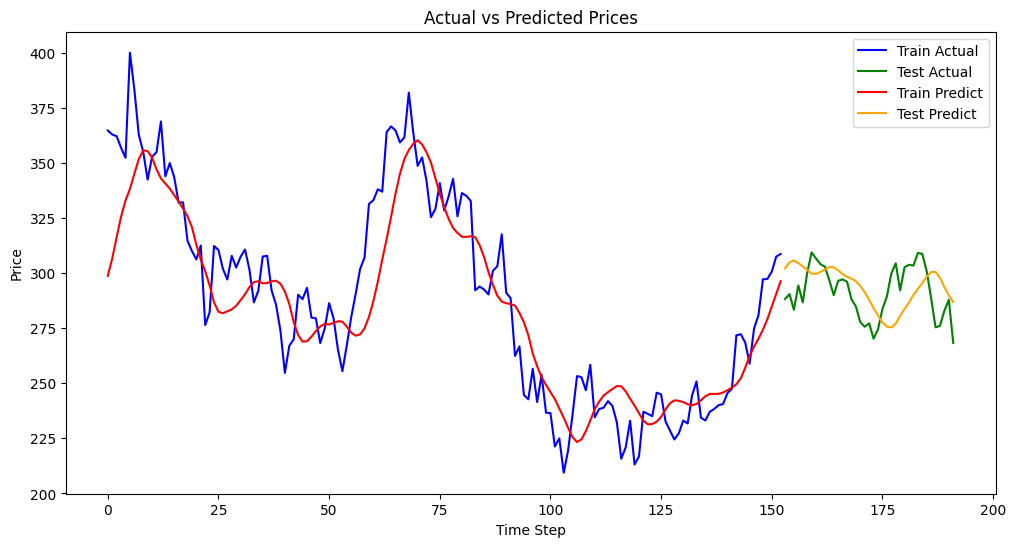

In [90]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Assuming 'series' is your DataFrame containing stock data

# Separate the target ('Close') and features
target = 'Close'
features = series.drop(columns=[target])

# Scale the features (X) using MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(features)

# Scale the target variable (y) using MinMaxScaler
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(series[[target]])

# Combine the scaled data to create the sequences
scaled_data = pd.DataFrame(X_scaled, columns=features.columns)
scaled_data[target] = y_scaled

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X_sequence = data.iloc[i:i+seq_length].values  # Use NumPy array directly
        X.append(X_sequence)
        y.append(data.iloc[i + seq_length][target])  # Target is 'Close' price after the sequence
    return np.array(X), np.array(y)  # Return as NumPy arrays

# Hyperparameters
seq_length = 60  # Number of time steps (days) to look back

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Reshape X for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))  # Shape: (samples, time steps, features)

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverse scaling for predictions (only for 'Close' column)
train_predict = scaler_y.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler_y.inverse_transform(test_predict.reshape(-1, 1))

# Reverse scaling for actual values
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train_actual)), y_train_actual, label='Train Actual', color='blue')
plt.plot(range(len(y_train_actual), len(y_train_actual) + len(y_test_actual)), y_test_actual, label='Test Actual', color='green')
plt.plot(range(len(train_predict)), train_predict, label='Train Predict', color='red')
plt.plot(range(len(train_predict), len(train_predict) + len(test_predict)), test_predict, label='Test Predict', color='orange')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()
